## Problem description

We can certainly say that the topic of gender inequality has never been as heard and discussed as it is now: in fact, it is reasonable to say that, along with discrimination on the basis of race or sexuality, it is one of the most felt topics in civil society. And like all important issues, it is difficult to describe it rigorously and without raising controversy.

At the same time we can also say that the world of cinema is often a mirror of society, and not infrequently it is used as a thermometer to speculate on various sociological aspects: watching an old film we can in fact have an interpretation of how the society of the time saw itself and the world.

That said, the intention of the project should not now seem secret: the idea is to try to get some clues about the theme of gender in the world of cinema. The goal is far from having an exhaustive view of this aspect and was chosen for a number of reasons
- Many resources are available regarding cinema, though as we will see this does not mean that these are comprehensive
- It's a hot topic, so we'll have to make opinionated and justified choices from start to finish
- It shows how difficult it can be to answer wide-ranging questions

### Data sources
As mentioned earlier, many resources are available on the web regarding the world of film. Here we list just a few of them

- The Movie Database (TMDb)
- IMDb
- Utelly
- GoWATCH
- Entertaiment Data Hub
- uNoGS
- Streamzui

In particular, TMDb is one of the most used: it's a community-driven database dating back to 2008 with a strong international focus and wide breadth of data. For example, the [TMDB 5000 Movie Dataset](https://www.kaggle.com/tmdb/tmdb-movie-metadata) was built using the TMDB API and is widely used in the field of recommendation systems. However in our case we prefer to use the TMDB API for two reasons
- The dataset contains "only" 5k titles out of the +300k titles declared by TMDB
- The dataset is not up to date

We chose to build our dataset considering films released from the year 1950 to the present by querying the TMDB API, and for each film we are going to consider information regarding the gender of the cast. Various approaches can be considered in assessing whether there is a disparity between genders in a given film: these can range from the prevalence for certain roles, to the amount of time set aside relative to the length of the film. Each measure has its pros and cons, all of which are highly opinionated. For simplicity's sake, we will limit ourselves to considering a purely frequency measure: the number of people of a given gender in the cast of a film.

## Data gathering and storage

We identify two possible ways to collect this data
1. Rely on the [Daily File Exports](https://developers.themoviedb.org/3/getting-started/daily-file-exports): these archives provide a set of securely valid identifiers that can be used to query more information
2. Using the [Discover call](https://developers.themoviedb.org/3/discover/movie-discover): this call is quite flexible and allows to use various parameters to search for movies in the dataset

In our case the second method seems to have some advantages over the first one
- We can query the dataset in an orderly fashion, for example in descending chronological order, instead of relying on an identifier that does not give any information about the film itself
- Each call can return multiple results, which are paged to be consulted sequentially
- The amount of data, although reduced compared to the first method, is sufficient for our investigation

We also take into account the fact that in both cases we do not immediately have information about the cast, for which we will need in any case to make an ad-hoc call.

That said, our approach will be to query the API, year by year, from the year 2020 to the year 1950. Below we can see the format of the response given by this method.

![title](img/responses.jpg)

As already mentioned, we need more information: for this reason we need to make, for each film, a second call providing information about the cast. We ask for the list of credits using the [Credits call](https://developers.themoviedb.org/3/movies/get-movie-credits). Below we can see the format of the response given by the method.

![title](img/credits.jpg)

Since we are going to limit the measure to people who appear in front of the camera lens, we can omit the crew. Given the cast, we can consider various approaches to storing this information
- We can store the entire cast information: this considerably increases the amount of information we would be storing and the complexity of it, when much of it is beyond our specific interest.
- We can limit ourselves to gender information: we can store individual actors and their gender, if not simply aggregate this information with a simple counter.

Before continuing, however, we must make some considerations about the gender field that is returned in the response: as explained in [this](https://www.themoviedb.org/talk/5a0cbf41c3a36812ed00024c) post by the founder of the TMDB service, the field can take the following values
- 1 for Female
- 2 for Male
- 0 for Not set / not specified. The field collects all cases where the person is not explicitly censused as one of the previous two genders, so it is a default case. This means that it can be either missing information or unspecified information (an interesting discussion of this is made [here](https://www.themoviedb.org/talk/58ee5022c3a3683ded00a887)).

These cases can open a small parenthesis that is worth mentioning as a mere example of how complex it can be to manage some information: a very topical subject now is precisely the gender identity, ranging from legal to cultural recognition. Something that was given as established in the past without reservation may no longer be so in the near future.

However, in our case it will be reasonable to consider the field in most cases as simply unavailable information. We would then aggregate this information using a separate counter for the three case studies.

We are going to use a No-SQL storing system, MongoDB, since most of the provided information is declared as optional and returned in JSON format, easy to store using this type of database.

In [1]:
import tmdbsimple as tmdb
import time
from requests import HTTPError

tmdb.API_KEY = '34ed3ca4d3adae63d1bed1b1598bfbbb'

In [2]:
import sys
from pymongo import MongoClient
import json

client = MongoClient('localhost', 27017, username='mongoadmin', password='pass1234')
database = client['bda']

In [3]:
movies = database.movies
discover_search = tmdb.Discover()

max_retries = 3


for year in reversed(range(1950, 2021)):
    start = time.time()
    print("Retrieving movies for year {0}...".format(year))
    info_results = discover_search.movie(page=1, primary_release_year=year)
    
    for page in range(1, info_results['total_pages'] + 1):
        response = discover_search.movie(page=page, primary_release_year=year)['results']
        movies_with_credits = []
        for entry in response:
            for retry in range(max_retries):
                try:
                    movies_search = tmdb.Movies(id=entry['id'])
                    credits = movies_search.credits()
                    entry['count_cast_gender_0'] = 0
                    entry['count_cast_gender_1'] = 0
                    entry['count_cast_gender_2'] = 0
                    for cast_member in credits['cast']:
                        if cast_member['gender'] == 1:
                            entry['count_cast_gender_1'] += 1
                        elif cast_member['gender'] == 2:
                            entry['count_cast_gender_2'] += 1
                        else:
                            entry['count_cast_gender_0'] += 1
                    movies_with_credits.append(entry)
                    break
                except HTTPError as e:
                    if e.response.status_code in [404, 401] :
                        break
                    if e.response.status_code in [500, 502, 503, 504] :
                        print("{0}: retry {1}".format(e.response.status_code, retry + 1))
                        time.sleep(retry**2)
                        pass
                    else:
                        raise
        if len(movies_with_credits) > 0:
            movies.insert_many(movies_with_credits)
    
    end = time.time()
    print("Done in {0} minutes".format((end - start) // 60))


Retrieving movies for year 2020...
Done in 19.0 minutes
Retrieving movies for year 2019...
Done in 17.0 minutes
Retrieving movies for year 2018...
Done in 31.0 minutes
Retrieving movies for year 2017...
Done in 32.0 minutes
Retrieving movies for year 2016...
Done in 32.0 minutes
Retrieving movies for year 2015...
Done in 32.0 minutes
Retrieving movies for year 2014...
Done in 32.0 minutes
Retrieving movies for year 2013...
Done in 32.0 minutes
Retrieving movies for year 2012...
Done in 31.0 minutes
Retrieving movies for year 2011...
Done in 31.0 minutes
Retrieving movies for year 2010...
Done in 31.0 minutes
Retrieving movies for year 2009...
Done in 32.0 minutes
Retrieving movies for year 2008...
Done in 37.0 minutes
Retrieving movies for year 2007...
502: retry 1
502: retry 2
502: retry 3
502: retry 1
502: retry 2
502: retry 3
502: retry 1
502: retry 2
502: retry 3
502: retry 1
502: retry 2
502: retry 3
502: retry 1
502: retry 2
502: retry 3
502: retry 1
502: retry 2
502: retry 3
Don

In [5]:
#movies.remove({})
movies.count_documents({})

351017

The genre field contains a list of identifiers for which we need to retrieve the relevant nomenclature.

In [6]:
genres = database.genres
tmdb.API_KEY = '34ed3ca4d3adae63d1bed1b1598bfbbb'
search = tmdb.Genres()
response = search.movie_list(page=page,primary_release_year=year)['genres']
genres.insert_many(response)

In [7]:
#genres.remove({})
genres.count_documents({})

19

## Data description

In [2]:
from pymongo import MongoClient

client = MongoClient('localhost', 27017, username='mongoadmin', password='pass1234')
database = client['bda']

We are only interested in evaluating a few fields, so we proceed to select these before loading the dataset

In [3]:
import pandas as pd

movies = database.movies
cursor = movies.find({},{ 'genre_ids': 1, 'id': 1, 'original_title': 1, 'original_language': 1, 'release_date': 1, 'count_cast_gender_0': 1, 'count_cast_gender_1': 1, 'count_cast_gender_2': 1, '_id': 0 })
moviesdf = pd.DataFrame(list(cursor))

We first want to get a broad view of the dataset

In [4]:
moviesdf.head()

,genre_ids,id,original_language,original_title,release_date,count_cast_gender_0,count_cast_gender_1,count_cast_gender_2
0,"[12, 14, 10751, 16]",529203,en,The Croods: A New Age,2020-11-25,0,6,6
1,"[28, 53, 80, 18]",553604,en,Honest Thief,2020-09-03,5,2,8
2,"[28, 53, 878]",577922,en,Tenet,2020-08-22,19,5,21
3,"[53, 80, 9648]",646593,en,Wander,2020-12-04,5,6,5
4,"[28, 53]",524047,en,Greenland,2020-07-29,3,8,13


We also see below how the dataset doesn't contain null values in any column

In [5]:
moviesdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351017 entries, 0 to 351016
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   genre_ids            351017 non-null  object
 1   id                   351017 non-null  int64 
 2   original_language    351017 non-null  object
 3   original_title       351017 non-null  object
 4   release_date         351017 non-null  object
 5   count_cast_gender_0  351017 non-null  int64 
 6   count_cast_gender_1  351017 non-null  int64 
 7   count_cast_gender_2  351017 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 21.4+ MB


In [6]:
moviesdf.isna().sum()

genre_ids              0
id                     0
original_language      0
original_title         0
release_date           0
count_cast_gender_0    0
count_cast_gender_1    0
count_cast_gender_2    0
dtype: int64

## Data cleaning

Are there duplicates? To check this we use the id field, since we actually have to consider the case of movies with the same name.

In [7]:
moviesdf[moviesdf.duplicated(['id'])]

,genre_ids,id,original_language,original_title,release_date,count_cast_gender_0,count_cast_gender_1,count_cast_gender_2
21701,"[80, 28, 10749]",534134,en,Blackbird,2018-09-24,2,1,3
61871,"[12, 10751]",285191,no,Kaptein Sabeltann og skatten i Lama Rama,2014-09-26,0,3,13
124770,"[35, 18]",82956,de,Die Schimmelreiter,2008-09-28,12,5,14
297678,"[878, 14]",696457,ja,Mirror Man: Dinosaur Aroza Reanimated,1972-07-22,0,1,1
297718,[35],686310,el,Πώς Καταντήσαμε Σωτήρη!..,1972-01-10,12,6,8
...,...,...,...,...,...,...,...,...
329789,[35],596408,fi,Miljoonavaillinki,1961-09-29,0,3,5
329790,[18],595057,de,100 000 Dollar Belohnung,1961-04-09,1,2,1
329791,[18],595054,de,Der Strafverteidiger,1961-11-23,2,1,4
329792,[16],594441,en,Hamilton The Musical Elephant,1961-04-12,0,0,0


Let's remove these duplicates

In [8]:
moviesdf = moviesdf.drop_duplicates(subset=['id'])

The given release date is in string format, so we need to change this in datetime format

In [9]:
moviesdf['release_date'] = pd.to_datetime(moviesdf['release_date'])

In [10]:
print(moviesdf.dtypes)

genre_ids                      object
id                              int64
original_language              object
original_title                 object
release_date           datetime64[ns]
count_cast_gender_0             int64
count_cast_gender_1             int64
count_cast_gender_2             int64
dtype: object


We can also see how the language is a categorical field, so we can change its type to categorical

In [11]:
moviesdf['original_language'].unique()

array(['en', 'de', 'ko', 'es', 'fr', 'it', 'ja', 'pt', 'ru', 'no', 'zh',
       'sv', 'pl', 'hi', 'da', 'ro', 'wo', 'bn', 'ca', 'sr', 'cn', 'id',
       'uk', 'cs', 'tl', 'ta', 'ar', 'fi', 'sk', 'gl', 'nl', 'te', 'el',
       'he', 'tr', 'th', 'ml', 'ms', 'mk', 'fa', 'kn', 'et', 'lv', 'kk',
       'hu', 'af', 'ka', 'lt', 'yi', 'ak', 'hr', 'hy', 'xx', 'pa', 'sw',
       'ce', 'bg', 'eu', 'gu', 'vi', 'tg', 'lo', 'dz', 'be', 'ha', 'is',
       'gd', 'la', 'az', 'mg', 'my', 'nb', 'mr', 'bs', 'mn', 'or', 'ky',
       'uz', 'cy', 'sq', 'sl', 'ab', 'km', 'bo', 'as', 'si', 'ur', 'sa',
       'ny', 'am', 'ga', 'ne', 'os', 'ln', 'ps', 'ku', 'zu', 'jv', 'rm',
       'nn', 'lb', 'ay', 'so', 'hz', 'xh', 'sm', 'iu', 'rw', 'oc', 'qu',
       'eo', 'tk', 'bm', 'su', 'mt', 'fo', 'ss', 'za', 'ch', 'ba', 'sh',
       'ht', 'mi', 'sn', 'se', 'mh', 'gv', 'kw', 'gn', 'dv', 'aa', 'kl',
       'yo', 'ti', 'nv', 'tt', 'cr', 'ts', 'ks', 'co', 'to', 'mo', 'fy',
       'ug', 'ig', 'ff', 'ik', 'ty', 'sd'], dtype=o

In [12]:
moviesdf['original_language'] = moviesdf.original_language.astype('category')

In [13]:
print(moviesdf.dtypes)

genre_ids                      object
id                              int64
original_language            category
original_title                 object
release_date           datetime64[ns]
count_cast_gender_0             int64
count_cast_gender_1             int64
count_cast_gender_2             int64
dtype: object


We must now deal with the `genre_ids` field, which contains a list of integers (the order doesn't matter). To do this we can use various approaches, but the one that seems more convenient is to create a boolean column for each category. This will help us to consult this information during the analysis part.

In [14]:
cursor = database.genres.find({}, {'_id': 0 })
genresdf = pd.DataFrame(list(cursor))
genresdf

,id,name
0,28,Action
1,12,Adventure
2,16,Animation
3,35,Comedy
4,80,Crime
5,99,Documentary
6,18,Drama
7,10751,Family
8,14,Fantasy
9,36,History


In [15]:
moviesdf['genre_ids'].head().apply(pd.Series)

def boolean_df(item_lists, unique_items):
    bool_dict = {}
    for i, item in enumerate(unique_items):
        bool_dict[item] = item_lists.apply(lambda x: item in x)
    return pd.DataFrame(bool_dict)

genres_bool = boolean_df(moviesdf['genre_ids'], genresdf['id'])
#Rename columns
genres_bool.columns = genresdf['name']

In [16]:
moviesdf = moviesdf.drop('genre_ids', axis=1)
moviesdf = pd.concat([moviesdf, genres_bool], axis=1).reindex(moviesdf.index)

## Data analysis

Before going on with the analysis, we should check how often cast member have `gender=0`?

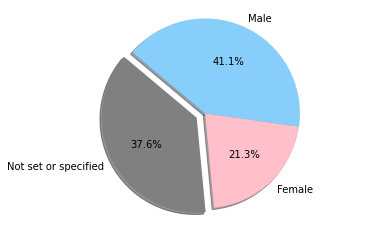

In [17]:
import matplotlib.pyplot as plt

# Data to plot
labels = 'Not set or specified', 'Female', 'Male'
sizes = [
    moviesdf.count_cast_gender_0.sum(),
    moviesdf.count_cast_gender_1.sum(),
    moviesdf.count_cast_gender_2.sum()]
colors = ['grey', 'pink', 'lightskyblue']
explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In fact, an important part of the cast turns out to have this value for the gender. How much can this factor affect our analysis? Let's take a look at the titles with the highest number of cases with `gender=0`


In [18]:
moviesdf_nog = moviesdf.sort_values(by=['count_cast_gender_0'], ascending=False).head()
moviesdf_nog

,id,original_language,original_title,release_date,count_cast_gender_0,count_cast_gender_1,count_cast_gender_2,Action,Adventure,Animation,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
129982,4523,en,Enchanted,2007-11-20,192,32,25,False,False,False,...,False,False,False,False,True,False,False,False,False,False
20154,458423,en,Mamma Mia! Here We Go Again,2018-07-09,163,35,28,False,False,False,...,False,False,False,False,True,False,False,False,False,False
113383,36400,pl,Popieluszko. Wolnosc jest w nas,2009-02-27,161,7,15,False,False,False,...,True,False,False,False,False,False,False,False,False,False
167125,10105,en,Saints and Soldiers,2003-09-11,153,0,11,True,True,False,...,True,False,False,False,False,False,False,False,True,False
10420,593691,en,Homecoming: A Film by Beyoncé,2019-04-17,146,12,5,False,False,False,...,False,False,True,False,False,False,False,False,False,False


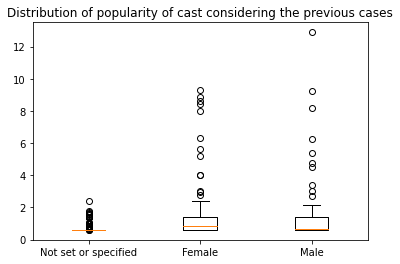

In [19]:
import tmdbsimple as tmdb
import time
from requests import HTTPError

tmdb.API_KEY = '34ed3ca4d3adae63d1bed1b1598bfbbb'

popularity_by_gender = [[],[],[]]
for id in list(moviesdf_nog['id']):
    movies_search = tmdb.Movies(id=id)
    for cast_member in movies_search.credits()['cast']:
        popularity_by_gender[cast_member['gender']].append(cast_member['popularity'])

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xticklabels(['Not set or specified', 'Female', 'Male']) 
ax.set_title('Distribution of popularity of cast considering the previous cases')
ax.boxplot(popularity_by_gender)

plt.show()

Some considerations before continuing
- The tendency of these `gender=0` cases seems to involve instances of appearances by actors not known to most (with low popularity), while notable actors do not seem to be affected by this shortcoming.
- It is not far-fetched to assume that this lack may equally penalize both male and female genders, especially considering the amount of data.
- Although the dataset is quite rich in titles, we need to remember that this is a community-driven work. In fact, we must consider that not only is some genre information missing, but that the casts themselves may be incomplete.

With the above in mind, we will ignore cast with `gender=0`.

First, can we see substantial differences between different decades?

We set the `release_date` column as an index: working with a datetime index provides powerful functionalities.

In [20]:
moviesdf_dateindexed = moviesdf.set_index('release_date')

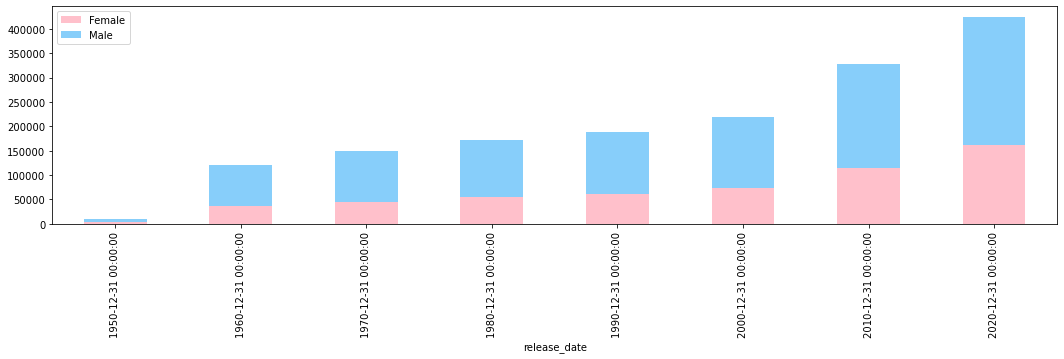

In [21]:
def count_cast_gender(x):
    g1 = x['count_cast_gender_1'].sum()
    g2 = x['count_cast_gender_2'].sum()
    return pd.Series([g1,g2], index=['Female','Male'])

moviesdf_dateindexed.groupby(pd.Grouper(freq='10Y',label='right')).apply(count_cast_gender).plot.bar(figsize=(18, 4), stacked=True, color = ['pink', 'lightskyblue'])

From the above graph we can see two facts
- Casts are increasing significantly from year to year: this is both due to an increase in the size of the film industry and a simple preference for newer films when it comes to the census
- The ratio between the two genders remains substantially unchanged, and favors the male gender in every era

In [22]:
def perc_gender(x):
    g1 = x['count_cast_gender_1'].sum()
    g2 = x['count_cast_gender_2'].sum()
    return pd.Series([100 * g1 /(g1+g2),100 * g2 /(g1+g2)], index=['Female','Male'])

moviesdf_dateindexed.groupby(pd.Grouper(freq='10Y',label='right')).apply(perc_gender)

,Female,Male
release_date,,
1950-12-31,28.144458,71.855542
1960-12-31,29.850512,70.149488
1970-12-31,30.412005,69.587995
1980-12-31,31.442943,68.557057
1990-12-31,32.067246,67.932754
2000-12-31,33.527533,66.472467
2010-12-31,35.139073,64.860927
2020-12-31,38.138139,61.861861


Can we identify differences in the relationship between genders with regard to film genres?

In [23]:
moviesdf.head()

,id,original_language,original_title,release_date,count_cast_gender_0,count_cast_gender_1,count_cast_gender_2,Action,Adventure,Animation,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,529203,en,The Croods: A New Age,2020-11-25,0,6,6,False,True,True,...,False,False,False,False,False,False,False,False,False,False
1,553604,en,Honest Thief,2020-09-03,5,2,8,True,False,False,...,False,False,False,False,False,False,False,True,False,False
2,577922,en,Tenet,2020-08-22,19,5,21,True,False,False,...,False,False,False,False,False,True,False,True,False,False
3,646593,en,Wander,2020-12-04,5,6,5,False,False,False,...,False,False,False,True,False,False,False,True,False,False
4,524047,en,Greenland,2020-07-29,3,8,13,True,False,False,...,False,False,False,False,False,False,False,True,False,False


In [24]:
categories_count_female = []
categories_count_male = []
catgs = moviesdf.columns[-19:-1]
for category_col in catgs:
    df = moviesdf.groupby(category_col).agg({'count_cast_gender_1': ['sum'], 'count_cast_gender_2': ['sum']}).reset_index()
    categories_count_female.append(df[1:]['count_cast_gender_1', 'sum'][1])
    categories_count_male.append(df[1:]['count_cast_gender_2', 'sum'][1])

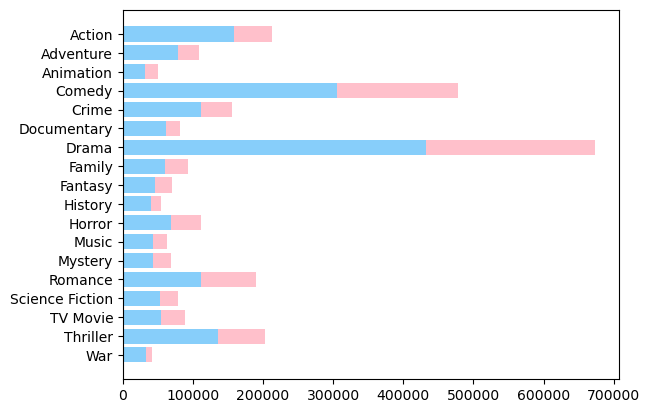

In [25]:
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(catgs))
ax.barh(y_pos, categories_count_male, color='lightskyblue')
ax.barh(y_pos, categories_count_female, left=categories_count_male, color='pink')
ax.set_yticks(y_pos)
ax.set_yticklabels(catgs)
ax.invert_yaxis()

plt.show()

From the previous graph we can observe that
- As might be expected, there are significant differences between the amount of films featured by genre
- The most popular categories are Drama, Comedy and Action
- Variations in gender ratio are significant between different film genres: while the Romance genre is the most balanced, the War genre turns out to have the most gender inequality

In [26]:
for i in range(len(catgs)):
    fp = 100 * categories_count_female[i] / (categories_count_female[i] + categories_count_male[i])
    mp = 100 * categories_count_male[i] / (categories_count_female[i] + categories_count_male[i])
    print('{:}: {:.2f}% female, {:.2f}% male'.format(catgs[i], fp, mp))

Action: 25.82% female, 74.18% male
Adventure: 27.76% female, 72.24% male
Animation: 36.79% female, 63.21% male
Comedy: 36.08% female, 63.92% male
Crime: 29.08% female, 70.92% male
Documentary: 24.06% female, 75.94% male
Drama: 35.73% female, 64.27% male
Family: 35.79% female, 64.21% male
Fantasy: 35.74% female, 64.26% male
History: 24.79% female, 75.21% male
Horror: 38.46% female, 61.54% male
Music: 32.29% female, 67.71% male
Mystery: 36.01% female, 63.99% male
Romance: 41.30% female, 58.70% male
Science Fiction: 31.47% female, 68.53% male
TV Movie: 38.63% female, 61.37% male
Thriller: 33.22% female, 66.78% male
War: 20.61% female, 79.39% male


What about the language of the film? Are there differences in gender ratio between films of different languages? The number of languages surveyed is quite large, 149, but we want to focus on languages with a relevant cast size. We therefore filter with a minimum cast size, set at 5000 per gender.

In [91]:
lang_count_female = []
lang_count_male = []
langs = moviesdf['original_language'].unique()

lang_df = moviesdf.groupby('original_language').agg({'count_cast_gender_1': ['sum'], 'count_cast_gender_2': ['sum']}).reset_index()
lang_df.columns = ['Language', 'Female', 'Male']
lang_df['Male (%)'] = 100 * lang_df['Male'] / (lang_df['Female'] + lang_df['Male'] )
lang_df = lang_df[(lang_df['Female']>5000) & (lang_df['Male']>5000)]
lang_df = lang_df.sort_values(by='Male (%)', ascending=False)
lang_df

,Language,Female,Male,Male (%)
82,ml,5503,15392,73.663556
19,cn,7675,18300,70.452358
106,ru,13490,31880,70.266696
147,zh,7780,17292,68.969368
22,cs,7588,16396,68.362241
124,ta,5787,12462,68.288673
29,en,269850,528177,66.185355
58,it,18812,36536,66.011419
48,hi,7377,14253,65.894591
60,ja,35456,65401,64.845276


Considering these data, we can see some significant differences between different languages that, however, are not easy to explain. It is rather interesting to note that this disparity between male and female genres is a constant between different languages.

## Conclusions

As stated above, we made only a quantitative evaluation, without distinguishing between main and minor roles. However, by analyzing several aspects of the dataset, we were able to see that there is in fact a disparity between the size of the male and female casts.